In [205]:
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl as xl
import numpy as np

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit


In [206]:
file_path = r"C:\Users\jsoli\Downloads\TxCD.xlsx"
type_tx = "CD"
deform = 14
cohesion = True

In [207]:
DataTx = {}

workbook = xl.load_workbook(file_path)

for sheet in workbook:
    p0 = int(sheet.title.split("-")[1])

    df_tx = pd.read_excel(file_path,sheet_name=sheet.title)

    DataTx[sheet.title] = {"p0":p0,"df":df_tx}

workbook.close()

In [208]:
for key in DataTx.keys():

    df = DataTx[key]["df"]
    df["σ3"] = DataTx[key]["p0"]
    df["σ1"] = df["σ3"] + df["desv (kPa)"]
    df["p"] = (df["σ1"] + df["σ3"]) / 2
    df["q"] = (df["σ1"] - df["σ3"]) / 2

    if type_tx == "CD":
        df["σ3'"] = df["σ3"]
        df["σ1'"] = df["σ1"]
        df["p'"] = df["p"]
    else:
        df["σ3'"] = df["σ3"] - df["u (kPa)"]
        df["σ1'"] = df["σ1"] - df["u (kPa)"]
        df["p'"] = df["p"] - df["u (kPa)"]

    DataTx[key]["df"] = df


In [209]:
q_list = []
p_list = []

sigv_list = []
tau_list = []

for key in DataTx.keys():
    
    df = DataTx[key]["df"]
    
    f1 = interp1d(df["e1 (%)"], df["p"])
    f2 = interp1d(df["e1 (%)"], df["q"])
    f3 = interp1d(df["e1 (%)"], df["desv (kPa)"])
    
    p_def = f1(deform)
    q_def = f2(deform)
    desv_def = f3(deform)
    
    DataTx[key]["p"] = p_def
    DataTx[key]["q"] = q_def
    DataTx[key]["desv"] = desv_def
    
    p_list.append(p_def)
    q_list.append(q_def)

    sigv_list.append(p_def-q_def**2/p_def)
    tau_list.append((q_def**2-q_def**4/p_def**2)**0.5)

In [255]:
def MC(x,a,b):
    return a*x+b
def MC_c(x,a):
    return a*x
def Power_curve(x,a,b):
    return a*x**b
def Leps(x, a, b):
    return x * np.tan(a * np.log(x / 1000) + b)

In [256]:
popt1, pocv1 = curve_fit(MC, p_list, q_list)
popt2, pocv2 = curve_fit(MC_c, p_list, q_list)
popt3, pocv3 = curve_fit(Power_curve, sigv_list, tau_list)
popt4, pocv4 = curve_fit(Leps,sigv_list, tau_list)

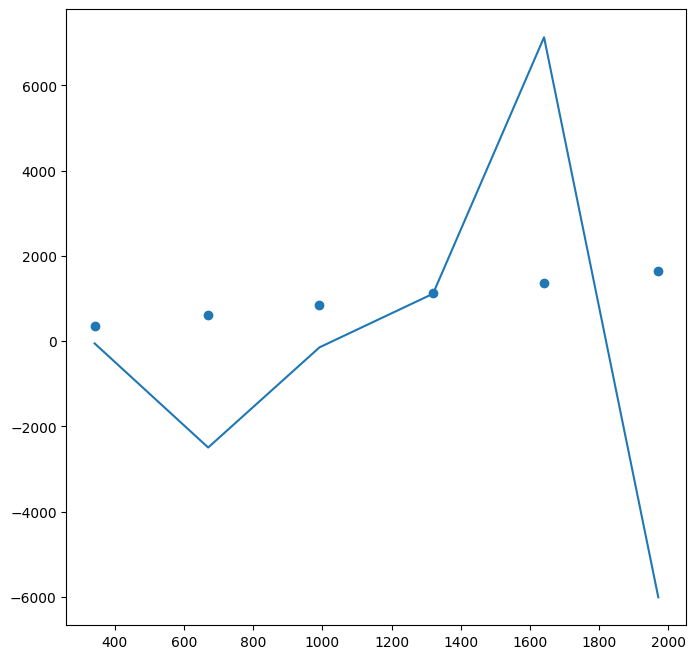

[np.float64(342.01848160898714),
 np.float64(670.1008747894214),
 np.float64(991.7931812266852),
 np.float64(1319.8940849508722),
 np.float64(1640.7723394701393),
 np.float64(1970.9113663791177)]

In [258]:
fig = plt.figure(figsize=(8,8))
plt.scatter(sigv_list,tau_list)
plt.plot(sigv_list,Leps(np.array(sigv_list),popt4[0],popt4[1]))
plt.show()
sigv_list

In [212]:
phi = np.arcsin(popt1[0])
c = popt1[1] / np.cos(phi)
phi2 = np.arcsin(popt2[0])

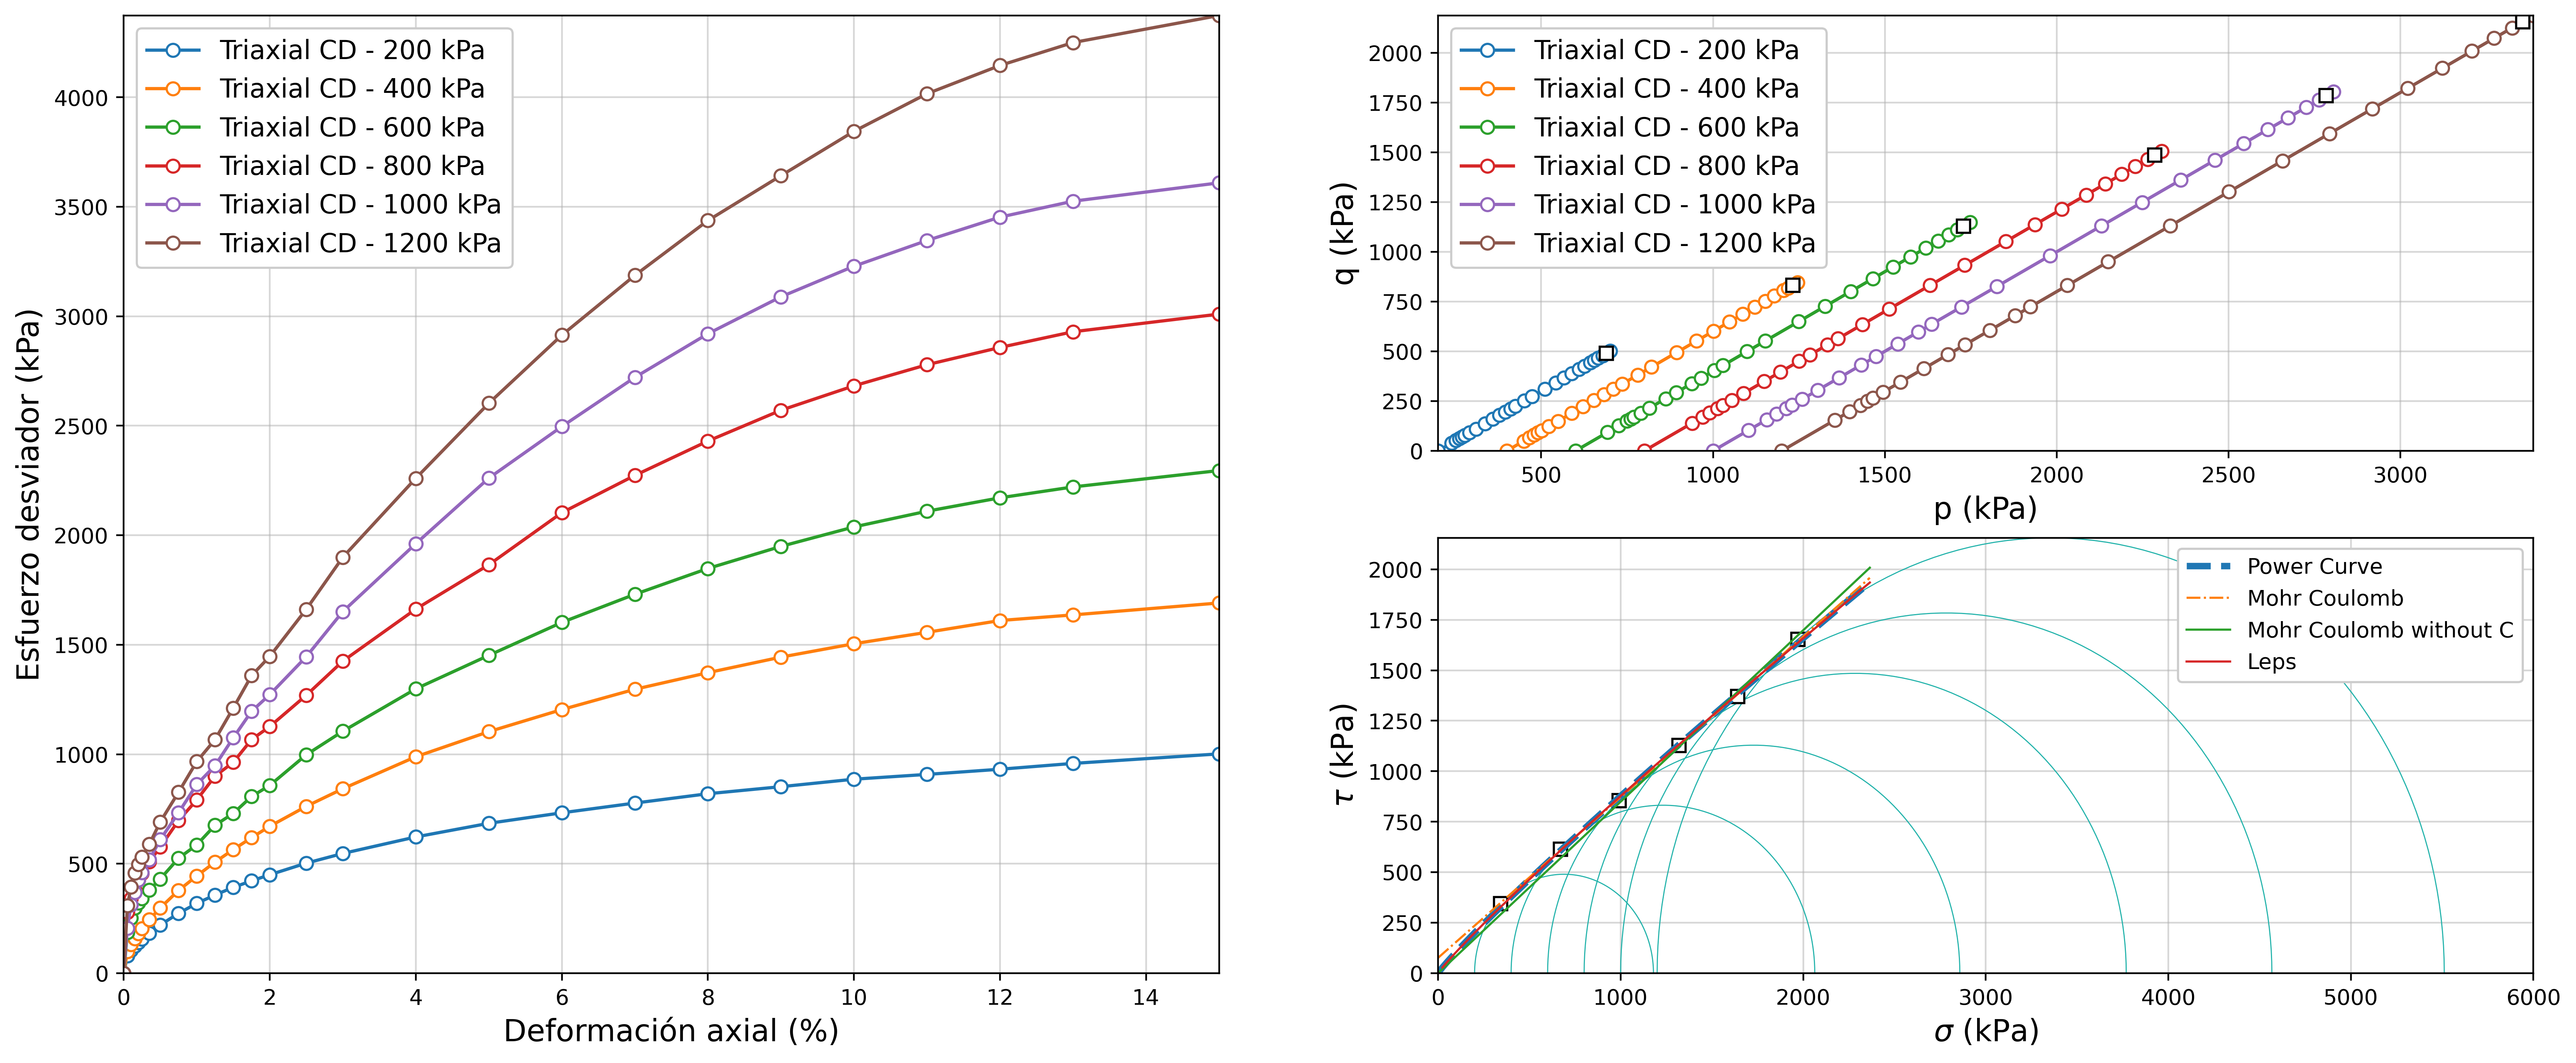

In [214]:
fig = plt.figure(figsize=(20,8), dpi=400)

gs = fig.add_gridspec(2,2)

#Esfuerzo deformación
ax1 = fig.add_subplot(gs[:,0])

for key in DataTx.keys():
    
    df = DataTx[key]["df"]
    p0 = DataTx[key]["p0"]

    ax1.plot(df["e1 (%)"],df["desv (kPa)"], marker="o",ms=6, mfc="w",label=f"Triaxial {type_tx} - {p0} kPa")
ax1.margins(0)
ax1.grid(alpha=0.5)
ax1.set_xlabel("Deformación axial (%)", fontsize=14)
ax1.set_ylabel("Esfuerzo desviador (kPa)", fontsize=14)

ax1.legend(framealpha=1, fontsize=12)

#P-Q
ax2 = fig.add_subplot(gs[0,1])
for key in DataTx.keys():
    
    df = DataTx[key]["df"]
    p0 = DataTx[key]["p0"]
    ax2.plot(df["p'"],df["q"], marker="o",ms=6, mfc="w",label=f"Triaxial {type_tx} - {p0} kPa")

ax2.plot(p_list,q_list,marker="s",color="k",mfc = "w", ls ="")

ax2.margins(0)
ax2.grid(alpha=0.5)
ax2.set_xlabel("p (kPa)", fontsize=14)
ax2.set_ylabel("q (kPa)", fontsize=14)

ax2.legend(framealpha=1, fontsize=12)

#MC
ax3 = fig.add_subplot(gs[1,1])
theta = np.linspace(0,np.pi,100)

for key in DataTx.keys():
    
    p = DataTx[key]["p"]
    q = DataTx[key]["q"]
    x = p + q*np.cos(theta)
    y = q*np.sin(theta)
    ax3.plot(x,y,color="LightSeaGreen", lw=0.5)

sigv = np.linspace(0, max(sigv_list)*1.2, 100)

ymax=ax3.get_ylim()[1]
ax3.set_xlim([0,ymax*2.5])

# Graficando las curvas ajustadas:
ax3.plot(sigv_list, tau_list, marker="s", color="k", mfc="w", ls="")
ax3.plot(sigv, popt3[0] * sigv ** popt3[1], label="Power Curve", lw=3, ls="--")
ax3.plot(sigv, c + np.tan(phi) * sigv, label="Mohr Coulomb", lw=1,ls="-.")
ax3.plot(sigv, np.tan(phi2) * sigv, label="Mohr Coulomb without C", lw=1)
sigv_filtered = sigv[sigv > 0]  # eliminar ceros y valores negativos
ax3.plot(sigv_filtered, sigv_filtered * np.tan(popt4[0] * np.log10(sigv_filtered / 1000) + popt4[1]), label="Leps", lw=1)
# Configuración del gráfico
ymax = ax3.get_ylim()[1]
ax3.set_xlim([0, 6000])
ax3.set_xlabel(r"$\sigma$ (kPa)", fontsize=14)
ax3.set_ylabel(r"$\tau$ (kPa)", fontsize=14)
ax3.grid(alpha=0.5)
ax3.margins(0)
ax3.legend(framealpha=1)

plt.show()